In [192]:
import pickle as pckl

# personal script
#import tokenize_review

import pandas as pd

import numpy as np

from sklearn.base import TransformerMixin
# from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt


from nltk.corpus import stopwords

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

%matplotlib inline

In [16]:
# adjustable parameters
num_features = 1000
num_topics = 10
num_top_words = 10
num_top_reviews = 3



In [122]:
df = pckl.load(open('ARK_14_pos_sents.pckl','rb'))
#df = df_full[(df_full['1day_deriv'] < 0) & (df_full['1day_forcast'] < -0.08)]
reviews = df['review']

In [89]:
df_14day = pckl.load(open('ARK_sorted_data_0122.pckl','rb'))

In [90]:
df_14day.head()

,review,upvoted,comment_upvotes,comment_funny_votes,early_review,time_of_review,minutes_played,playtime_2weeks,last_played,games_owned,author_reviews,purchased,free,upvotes,total_votes,percent_upvotes,cleaned_reviews
0,Do not be fooled.\nThis game will invade your ...,True,71,41,False,2016-04-18 07:48:44,330,0,2018-11-26 07:57:48,6501,132,False,False,1,1,1.0,fool gam invad subconscy play hour burn many s...
1,One of the most challenging puzzle games out t...,True,34,20,False,2016-04-18 08:43:07,245,0,2016-04-18 08:48:29,361,10,False,False,2,2,1.0,on challeng puzzl gam nev unfair mech push rol...
2,You have to play the game to understand it and...,True,14,0,False,2016-04-18 11:00:45,1445,0,2016-05-26 17:03:53,67,1,True,False,3,3,1.0,play gam understand solv puzzl real satisfy ev...
3,"This game, huh? What a package! \n\nRight from...",True,10,2,False,2016-04-18 12:27:56,400,0,2017-04-24 12:00:53,365,68,False,False,4,4,1.0,gam huh pack right word go gam lov op menu mak...
4,I bet you are wondering what this game is actu...,True,15,6,False,2016-04-18 12:38:16,4109,0,2017-02-15 17:05:17,493,3,False,False,5,5,1.0,bet wond gam act lik play wheth wor money revi...


In [454]:
ws_tokenizer = WhitespaceTokenizer()
lancaster = LancasterStemmer()
porter = PorterStemmer()
snowball = SnowballStemmer('english')

try:
    stopwords = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))

In [455]:
def cleanText(text):
    
    # import a dictionary of English contractions from another file
    from contractions import contractions_dict
    contraction_dict = contractions_dict

    # replace the contractions with their expanded form
    for contraction, expansion in contraction_dict.items():
        text = text.replace(contraction.lower(),expansion.lower())
    
    # get rid of newlines
    symbols = ['\'', '\"', '.', ',', '[', ']', '(', ')', '?', '!', '@', '$', '#', '&', '%']
    
    text = text.strip().replace('\n', ' ').replace('\r', ' ').replace('-',' ')
    
    for symbol in symbols:
        text = text.replace(symbol, '')

    # lowercase
    text = text.lower()

    return text

In [456]:
def gen_tokens(review, *args):

    ws_tokenized = ws_tokenizer.tokenize(review)
    #print(type(ws_tokenized),ws_tokenized[0])

    cleaned_tokens = []

    for token in ws_tokenized:
        if token not in stopwords:
            cleaned_tokens.append(token.lower().strip())
            
    #print(type(cleaned_tokens),cleaned_tokens[0])
    
    clean_tokens = ' '.join(cleaned_tokens)

    stemmed_tokens = []

    try:
        method = args[0]
    except:
        method = 'lancaster'

    if method == 'lancaster':
        for token in cleaned_tokens:
            #stemmed_tokens.append(lancaster.stem(token))
            stemmed_tokens.append(lancaster.stem(token.lower().strip()))

    elif method == 'porter':
        for token in cleaned_tokens:
            stemmed_tokens.append(porter.stem(token.lower().strip()))

    elif method == 'snowball':
        for token in cleaned_tokens:
            stemmed_tokens.append(snowball.stem(token.lower().strip()))

    stemmed_text = ' '.join(stemmed_tokens)

    return clean_tokens

In [457]:
def clean_and_tokenize(reviews):
    cleaned_reviews = []

    for review in reviews:
        review_tokens = []
        cleaned_text = cleanText(review)
        cleaned_reviews.append(gen_tokens(cleaned_text))
        
    return cleaned_reviews

In [5]:
#neg_forecasts = pckl.load(open('neg_forecasts_14day.pckl','rb'))

In [143]:
#full_df = pckl.load(open('ARK_14day_FULL2.pckl','rb'))

In [146]:
neg_indices = full_df.index[(full_df['pos_sent'] < full_df['pos_sent'].mean()) &
              (full_df['neg_sent'] > full_df['neg_sent'].mean()) &
              (full_df['1day_delta'] < -0.08)].tolist()

pos_indices = full_df.index[(full_df['pos_sent'] > full_df['pos_sent'].mean()) &
              (full_df['neg_sent'] < full_df['neg_sent'].mean()) &
              (full_df['1day_delta'] > 0.08)].tolist()

In [160]:
pos_tfidf = np.empty((0,num_features), int)

for i in pos_indices:
    pos_tfidf = np.append(pos_tfidf, transform_array[i])

In [473]:
df = pckl.load(open('ARK_14_pos_sents.pckl','rb'))
#df = df_full[(df_full['1day_deriv'] < 0) & (df_full['1day_forcast'] < -0.08)]
reviews = example_window['review']

In [474]:
cleaned = clean_and_tokenize(reviews)

In [475]:
example_window['cleaned_reviews'] = cleaned

In [476]:
num_features = 2000
num_topics = 20
num_top_words = 10
num_top_reviews = 3

In [477]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=num_features,
                             ngram_range=(1,2), 
                             max_df=0.9, min_df=3)

# use NMF model with the Frobenius norm
implement_nmf = NMF(n_components=num_topics,
                    random_state=1,
                    solver='mu',
                    beta_loss='frobenius')

In [478]:
transform = vectorizer.fit_transform(example_window['review'])
transform_array = transform.toarray()

In [479]:
# Non-negative matrix factorization (NMF) implementation W*H = original matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

W = implement_nmf.fit_transform(transform_array)
H = implement_nmf.components_

#### Sentiment analysis with _vaderSentiment_ package

In [480]:
def display_topics(vectorizer, clf, W, df, num_top_words, num_top_reviews):
    ''' Print out topics discovered by a model '''
    
    # get list of feature names
    feature_names = vectorizer.get_feature_names()
    
    # get vader sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()    
    
    # list of topics and reviews to return
    topics, sentiments, reviews = [], [], []
    
    # loop over all the topics
    for topic_id, topic in enumerate(clf.components_):
        
        sentiment_sum = 0
        
        # grab the list of words describing the topic
        word_list = []
        for i in topic.argsort()[:-num_top_words - 1:-1]:
            word_list.append(feature_names[i])
        
        # split words in case there are some bigrams and get unique set
        split_list = []
        for word in word_list:
            for split in word.split():
                split_list.append(split)
        topic_words = list(set(split_list))
        
        # append topic words as a single string
        topics.append(' '.join([word for word in topic_words]))
        
        # print topic number and topic words
        print('Topic #%02d: %s' % (topic_id+1, topics[-1]))

        # loop over reviews for each topic
        top_doc_indices = np.argsort( W[:,topic_id] )[::-1][0:num_top_reviews]
        
        for doc_index in top_doc_indices:
            
            # check that the review contains one of the topic words
            if any(word in df['cleaned_reviews'].iloc[doc_index].lower() for word in topic_words):
                
                # sentiment analysis
                vader = analyzer.polarity_scores(df['cleaned_reviews'].iloc[doc_index])
                
                # append current review to the list 
                reviews.append(df.iloc[doc_index].to_dict())
                reviews[-1]['topic']       = topic_id
                reviews[-1]['topic_words'] = ' '.join([word for word in topic_words])
                reviews[-1]['sentiment']   = vader['compound']
                
                sentiment_sum += vader['compound']
                
                #print('User %20s on %s with rating %s' % (df['reviewerName'].iloc[doc_index][:20], 
                                     #df['reviewTime'].iloc[doc_index], df['overall'].iloc[doc_index]))            
                #print("VADER: %f" % vader['compound'])
                #print(reviews[-1]['reviewText'])
            else:
                print("WARNING: TOPIC NOT IN DOCUMENT")
                            
            print()
        
        sentiments.append(sentiment_sum)
        
    return topics, sentiments, reviews

In [481]:
topics, sentiments, assc_reviews = display_topics(vectorizer, implement_nmf, W, example_window, num_top_words, num_top_reviews)

#(vectorizer, clf, W, df, n_top_words, n_top_documents)

Topic #01: like hate mind don survival games shit game recommend quickly



Topic #02: terrible takes frame need 10 instantly friend does game optimization



Topic #03: graphics cool raiding massive building dinos does runs help sucks



Topic #04: fuck instead paid bad dlc game finished pay trying



Topic #05: really graphics playing make 10 bad just minutes boring years



Topic #06: computer money hard good run bad shit best game lots



Topic #07: pvp ark fun issue items time pve experience server lost



Topic #08: idea need play people minutes great game problem love



Topic #09: computer ark level make games dinosaurs time optimized best game



Topic #10: pvp little playing play decent great game fix



Topic #11: fps lowest mid make gtx run dinosaurs graphic pc optimization



Topic #12: dinosaur house 10 amazing able stuff game max hours lose



Topic #13: buy game new support card don core update 12 crashes lot



Topic #14: ark stop make cool don actually play game frien

In [482]:
pckl.dump(topics,open('ARK_20neg_recent_topics.pckl','wb'))

In [398]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.dates import DateFormatter
from sklearn import preprocessing
from math import log

In [502]:
end = 70000#103106

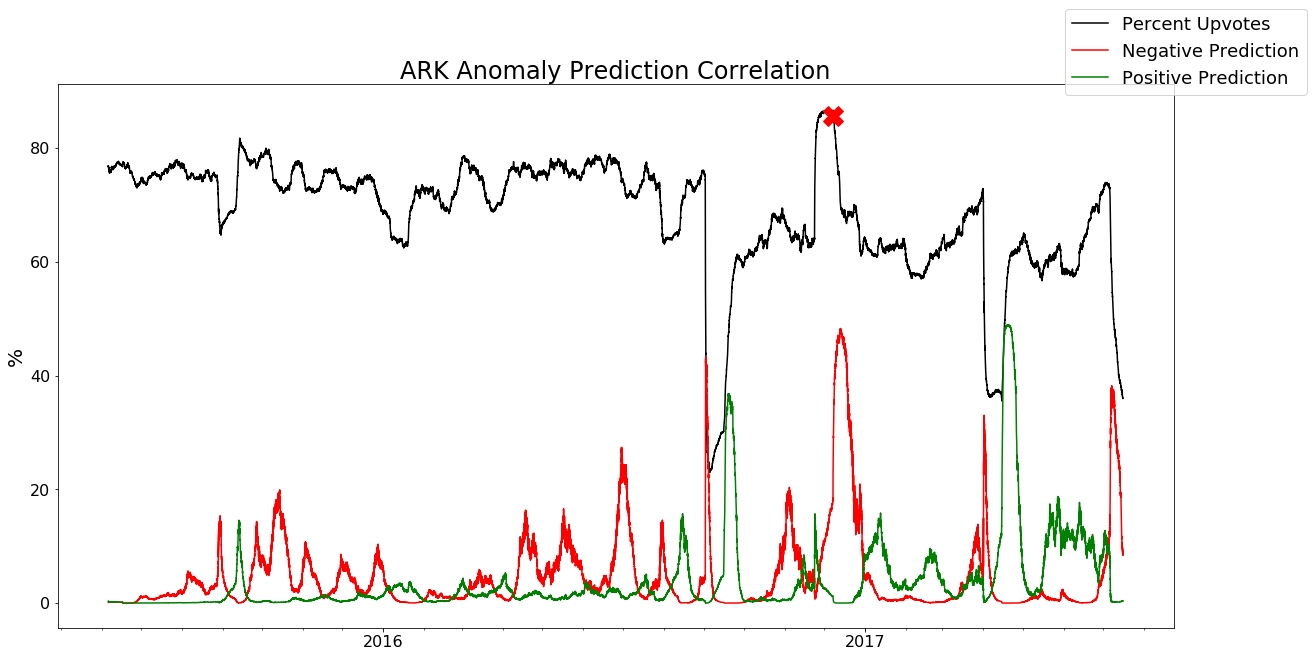

In [503]:
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

date = full_df['time_of_review'].iloc[2000:2000+end]

fig, ax = plt.subplots(figsize=(20,10))

percent_window = full_df['percent_window'].iloc[2000:2000+end]

ax.plot(date, 100*percent_window.values, 'k', date, 50*pd.Series(a)[:end].values, 'r',date, 50*pd.Series(b)[:end].values, 'g')
#ax.plot(date, prediction_scale, 'k', date, 100*percent_window.values)
plt.plot(date[52700], 100*percent_window[52700], 'rX',ms = 20)
 

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

fig.legend(['Percent Upvotes', 'Negative Prediction' , 'Positive Prediction'], loc='upper right', fontsize = 18)

plt.tick_params(axis='both', which='major', labelsize=16)

plt.xlabel('', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.title('ARK Anomaly Prediction Correlation', fontsize=24)

plt.show()

In [499]:
#fig.savefig('plots/ARK_dec816_example.png')

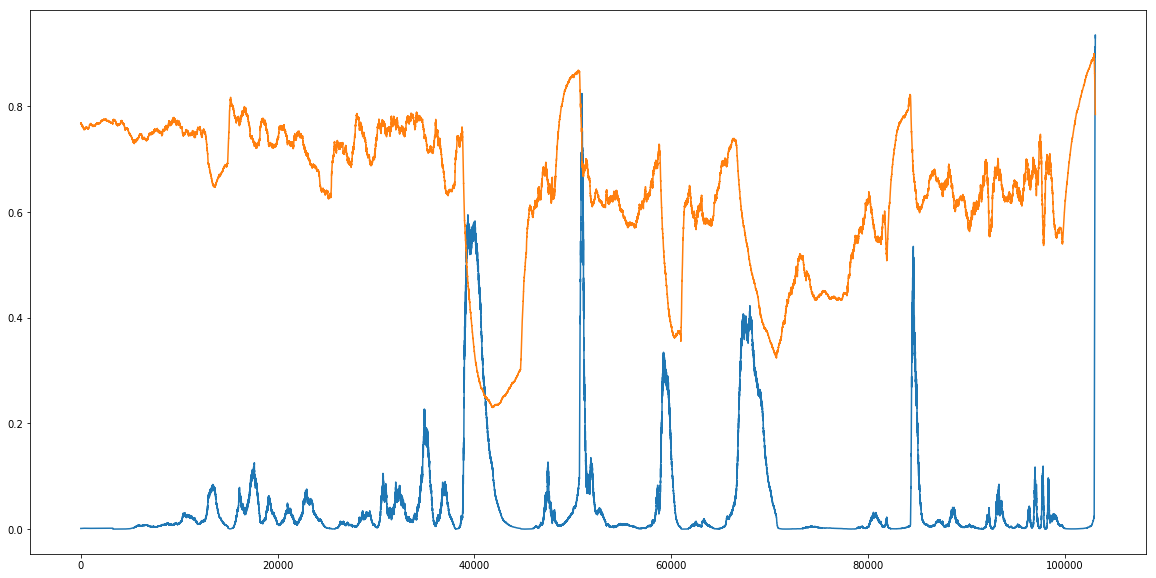

In [325]:
fig, ax = plt.subplots(figsize=(20,10))
x = pd.Series(range(len(predict_point_check)))

ax.plot(x, a, x, full_df['percent_window'].iloc[2000:-2000])

In [196]:
from sklearn import linear_model

In [208]:
#pckl.dump(full_df, open('ARK_14_full_class','wb'))

In [199]:
X = full_df[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']].iloc[2000:-2000]
Y = full_df['1day_forecast'].iloc[2000:-2000].copy()

dates = full_df['time_of_review']

In [203]:
Y_classes = []

for i in range(len(Y)):
    if Y.iloc[i] > Y.mean() + Y.std():
        Y_classes.append(1)
    elif Y.iloc[i] < Y.mean() - Y.std():
        Y_classes.append(-1)
    else:
        Y_classes.append(0)
        
Y_classification = pd.DataFrame({'class': Y_classes})

In [204]:
full_df['classification'] = Y_classification

In [206]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

train, test = train_test_split(full_df.iloc[2000:-2000], test_size=0.2)

In [207]:
x_train = train[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']]
x_test = test[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']]

y_train = train['1day_forecast']
y_test = test['1day_forecast']

In [209]:
y_mean = full_df['1day_forecast'].iloc[2000:-2000].mean()
y_std = full_df['1day_forecast'].iloc[2000:-2000].std()
print(y_mean, y_std)

-0.002395604253335573 0.03637083387345207


82484

In [210]:
y_train_classes = []


for i in range(len(y_train)):
    if y_train.iloc[i] > y_mean + y_std:
        y_train_classes.append(1)
    elif y_train.iloc[i] < y_mean - y_std:
        y_train_classes.append(-1)
    else:
        y_train_classes.append(0)
        
y_train_df = pd.DataFrame({'class': y_train_classes})

y_test_classes = []

for i in range(len(y_test)):
    if y_test.iloc[i] > y_mean + y_std:
        y_test_classes.append(1)
    elif y_test.iloc[i] < y_mean - y_std:
        y_test_classes.append(-1)
    else:
        y_test_classes.append(0)
        
y_test_df = pd.DataFrame({'class': y_test_classes})

In [440]:
weights = {-1: 30, 0: 1, 1: 30}

In [442]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1, solver='sag',
                         multi_class='multinomial', max_iter = 2000, class_weight = weights).fit(x_train.values, y_train_df.values)
                                                                        
predictions = clf.predict(x_test.values)

predict_prob = clf.predict_proba(x_test.values) 

score = clf.score(x_test, y_test_df.values)


/Users/tylerblair/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tylerblair/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [426]:
score

0.8989428765396179

In [303]:
testy = full_df['classification'].iloc[39000:45000]

In [305]:
predict_point = full_df[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']].iloc[39000:45000].values

In [388]:
predict_point_check = clf.predict_proba(full_df[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']].iloc[2000:-2000])
print(predict_point_check)

[[2.46007817e-03 9.90888708e-01 6.65121384e-03]
 [2.43751973e-03 9.90828343e-01 6.73413715e-03]
 [2.43827244e-03 9.90840328e-01 6.72139936e-03]
 ...
 [9.88579325e-01 1.13890279e-02 3.16473313e-05]
 [9.90203891e-01 9.77241034e-03 2.36982223e-05]
 [9.89267380e-01 1.07100132e-02 2.26071616e-05]]


In [390]:
a = [x[0] for x in predict_point_check]
len(a)

103106

In [416]:
prediction = []

for i in range(len(predict_point_check)):
    
    negative = predict_point_check[i][0]
    neutral = predict_point_check[i][1]
    positive = predict_point_check[i][2]
    
    if (neutral >= positive) & (neutral >= negative):
        prediction.append(0)
    elif (negative > neutral) & (negative > positive):
        prediction.append(-1)
    else:
        prediction.append(1)

In [421]:
prediction_scale = 50 + 25*pd.Series(prediction).values

In [292]:
full_df['1day_forecast'].describe()['25%']

-0.006514546584899555

In [132]:
#num_top_words = 5

num_features = 1000
num_topics = 20
num_top_words = 5 # words per topic
num_top_reviews = 1

In [131]:
#pckl.dump(topics,open('ARK_total_neg_sents.pckl','wb'))

In [70]:
#pckl.dump(top_topics, open('top_topics.pckl','wb'))

In [471]:
time = full_df['time_of_review_unix'].iloc[52700]
example_window = full_df[(full_df['time_of_review_unix'].between(time - 7*86400, time, inclusive=True)) & (full_df['neg_sent'] > full_df['neg_sent'].mean())].copy()

In [472]:
len(example_window)

84

In [159]:
# error = sqrt of sum of abs(matrix difference), i.e., how well did the refactorization work?
reconstruction_error = implement_nmf.reconstruction_err_

In [371]:
window_size = 100

#upvote_window = np.diff(df['upvotes'], n=1)
#zeros_upvote_window = np.zeros(window_size)

#full_upvote_window = 

In [379]:
upvote_window = []
percent_window = []

for i in range(len(df)):
    if i >= window_size - 1:
        upvote_period = df['upvotes'].iloc[i] - df['upvotes'].iloc[i+1-window_size]
        upvote_window.append(upvote_period)
        percent_window.append(upvote_period/window_size)
    else:
        upvote_window.append(df['upvotes'].iloc[i])
        percent_window.append(df['upvotes'].iloc[i]/df['total_votes'].iloc[i])

In [381]:
df.head()

,review,upvoted,comment_upvotes,comment_funny_votes,early_review,time_of_review,minutes_played,playtime_2weeks,last_played,games_owned,author_reviews,purchased,free,upvotes,total_votes,percent_upvotes,cleaned_reviews
0,Do not be fooled.\nThis game will invade your ...,True,71,41,False,2016-04-18 07:48:44,330,0,2018-11-26 07:57:48,6501,132,False,False,1,1,1.0,fool gam invad subconscy play hour burn many s...
1,One of the most challenging puzzle games out t...,True,34,20,False,2016-04-18 08:43:07,245,0,2016-04-18 08:48:29,361,10,False,False,2,2,1.0,on challeng puzzl gam nev unfair mech push rol...
2,You have to play the game to understand it and...,True,14,0,False,2016-04-18 11:00:45,1445,0,2016-05-26 17:03:53,67,1,True,False,3,3,1.0,play gam understand solv puzzl real satisfy ev...
3,"This game, huh? What a package! \n\nRight from...",True,10,2,False,2016-04-18 12:27:56,400,0,2017-04-24 12:00:53,365,68,False,False,4,4,1.0,gam huh pack right word go gam lov op menu mak...
4,I bet you are wondering what this game is actu...,True,15,6,False,2016-04-18 12:38:16,4109,0,2017-02-15 17:05:17,493,3,False,False,5,5,1.0,bet wond gam act lik play wheth wor money revi...


In [354]:
# data = df.reset_index(drop=True)

In [359]:
#ckl.dump(data,open('SSR_sorted_data_0122.pckl','wb'))

,review,upvoted,comment_upvotes,comment_funny_votes,early_review,time_of_review,minutes_played,playtime_2weeks,last_played,games_owned,author_reviews,purchased,free,upvotes,total_votes,percent_upvotes,cleaned_reviews
0,Do not be fooled.\nThis game will invade your ...,True,71,41,False,2016-04-18 07:48:44,330,0,2018-11-26 07:57:48,6501,132,False,False,1,1,1.0,fool gam invad subconscy play hour burn many s...
1,One of the most challenging puzzle games out t...,True,34,20,False,2016-04-18 08:43:07,245,0,2016-04-18 08:48:29,361,10,False,False,2,2,1.0,on challeng puzzl gam nev unfair mech push rol...
2,You have to play the game to understand it and...,True,14,0,False,2016-04-18 11:00:45,1445,0,2016-05-26 17:03:53,67,1,True,False,3,3,1.0,play gam understand solv puzzl real satisfy ev...
3,"This game, huh? What a package! \n\nRight from...",True,10,2,False,2016-04-18 12:27:56,400,0,2017-04-24 12:00:53,365,68,False,False,4,4,1.0,gam huh pack right word go gam lov op menu mak...
4,I bet you are wondering what this game is actu...,True,15,6,False,2016-04-18 12:38:16,4109,0,2017-02-15 17:05:17,493,3,False,False,5,5,1.0,bet wond gam act lik play wheth wor money revi...


In [141]:
cleaned_reviews = []

for review in reviews:
    review_tokens = []
    cleaned_text = cleanText(review)
    cleaned_reviews.append(gen_tokens(cleaned_text))

In [206]:
df['cleaned_reviews'] = cleaned_reviews

In [309]:
df['cleaned_reviews'].iloc[0]

'fool gam invad subconscy play hour burn many saus curs comput swear level imposs rag quit stil think day lat start gam attempt level fin solv yel triumph smil start process next level absolv bril sil frust weird amaz fun puzzl gam stop think also mak excel convers start poss convers end wel peopl walk away strange look fac youl brand weirdo profess lov rol saus around ground mind know tru tru beauty steph saus rol walk away smil eag get back gam solv on nef puzzl think week steph saus rol'

In [140]:
single_review = reviews[0]


cleaned_text = cleanText(single_review)
#cleaned_text

In [33]:
from nltk.tokenize import RegexpTokenizer
re_tokenizer = RegexpTokenizer(r'\w+')

regex_tokenized = re_tokenizer.tokenize(single_review)

In [37]:
regex_tokenized

['do',
 'not',
 'be',
 'fooled',
 'this',
 'game',
 'will',
 'invade',
 'your',
 'subconscious',
 'you',
 'will',
 'play',
 'for',
 'hours',
 'you',
 'will',
 'burn',
 'many',
 'sausages',
 'you',
 'will',
 'curse',
 'at',
 'your',
 'computer',
 'you',
 'will',
 'swear',
 'that',
 'level',
 'is',
 'impossible',
 'you',
 'will',
 'rage',
 'quit',
 'you',
 'will',
 'still',
 'be',
 'thinking',
 'about',
 'it',
 'days',
 'later',
 'you',
 'will',
 'start',
 'the',
 'game',
 'again',
 'and',
 'attempt',
 'a',
 'level',
 'again',
 'you',
 'will',
 'finally',
 'solve',
 'it',
 'you',
 'will',
 'yell',
 'in',
 'triumph',
 'and',
 'smile',
 'then',
 'you',
 'll',
 'start',
 'the',
 'process',
 'again',
 'on',
 'the',
 'next',
 'level',
 'it',
 's',
 'absolutely',
 'brilliant',
 'and',
 'silly',
 'and',
 'frustrating',
 'and',
 'weird',
 'it',
 'is',
 'an',
 'amazing',
 'and',
 'fun',
 'puzzle',
 'game',
 'that',
 'you',
 'll',
 'not',
 'stop',
 'thinking',
 'about',
 'it',
 's',
 'will',
 'als

In [8]:
single_review = reviews.iloc[0].lower()

In [26]:
from nltk.tokenize import WhitespaceTokenizer
ws_tokenizer = WhitespaceTokenizer()

In [32]:
ws_tokenized = ws_tokenizer.tokenize(single_review)

In [4]:
from nltk.corpus import stopwords

# nltk.download('stopwords') # if stopwords haven't been used before

stopwords = set(stopwords.words('english'))

In [55]:
ws_cleaned_tokens = []

for token in ws_tokenized:
    if token not in stopwords:
        ws_cleaned_tokens.append(token)

In [3]:
'''ws_tokenized = tokenize_review.tokenize(single_review)
stemmed_text = tokenize_review.full_review_stemmed(ws_tokenized)

## stemmed tokens or stemmed text for vectorization?
#stemmed_tokens = tokenize_review.stem_tokens(ws_tokenized)'''

NameError: name 'single_review' is not defined

In [28]:
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [5]:
stemmed_reviews = []

for review in reviews:
    ws_tokenized = tokenize_review.tokenize(review)
    stemmed_text = tokenize_review.full_review_stemmed(ws_tokenized)
    
    stemmed_reviews.append(stemmed_text)

In [20]:
df['stemmed_review'] = stemmed_reviews

In [27]:
'''
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(stemmed_reviews)
print(vectorizer.get_feature_names(), len(vectorizer.get_feature_names()))
'''

['10', '100', '11', '12', '132', '15', '15min', '16', '174', '19', '1990s', '1x1x1', '20', '2016', '2017', '2018', '21', '22', '220', '23gbp', '24', '25', '28', '29', '2d', '2nd', '2x1x1', '30', '31', '31803828', '32', '35', '352649', '36', '37', '3d', '3rds', '40', '400iq', '42', '45', '48', '4th', '50', '60', '64', '70', '80', '86', '87', '897', '90', '90s', '99', '_difficult_', 'aaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 'aback', 'abil', 'abilities', 'ability', 'abl', 'abound', 'about', 'abrupt', 'absolut', 'absolute', 'absolutely', 'abstract', 'absurd', 'abysmal', 'access', 'accessible', 'accid', 'accident', 'acclaim', 

In [46]:
def tokenize(review):

    ws_tokenized = ws_tokenizer.tokenize(review)

    cleaned_tokens = []

    for token in ws_tokenized:
        if token not in stopwords:
            cleaned_tokens.append(token)

    return cleaned_tokens

def stem_tokens(cleaned_tokens, *args):

    stemmed_tokens = []

    try:
        method = args[0]
    except:
        method = 'lancaster'

    if method == 'lancaster':
        for token in cleaned_tokens:
            stemmed_tokens.append(lancaster.stem(token))

    elif method == 'porter':
        for token in cleaned_tokens:
            stemmed_tokens.append(porter.stem(token))

    elif method == 'snowball':
        for token in cleaned_tokens:
            stemmed_tokens.append(snowball.stem(token))

    return stemmed_tokens

def full_review_stemmed(cleaned_tokens, *args):

    stemmed_tokens = []

    try:
        method = args[0]
    except:
        method = 'lancaster'

    if method == 'lancaster':
        for token in cleaned_tokens:
            stemmed_tokens.append(lancaster.stem(token))

    elif method == 'porter':
        for token in cleaned_tokens:
            stemmed_tokens.append(porter.stem(token))

    elif method == 'snowball':
        for token in cleaned_tokens:
            stemmed_tokens.append(snowball.stem(token))

    stemmed_text = ' '.join(stemmed_tokens)

    return stemmed_text

AttributeError: sortby not found

In [510]:
top20neg = pckl.load(open('ARK_20neg_topics.pckl','rb'))

In [506]:
topics = pd.DataFrame([])

In [511]:
topics['neg_20'] = top20neg

In [521]:
topics = topics.rename(columns = {'neg_20':'negative_20'})
topics.columns

Index(['positive_20', 'recent_20', 'negative_20'], dtype='object')

In [522]:
#pckl.dump(topics,open('ARK_dec8_topics.pckl','wb'))